## SST and Chlorophylla EOF Analysis
### Mauritania - Senegalese Upwelling Zone - 26ºN to 35ºN

In [1]:
from ocean_tools.io.readers import get_xarray_from_file
from ocean_tools.config.defaults import REGIONS
from ocean_tools.processing.data_prep import prepare_dataset_for_analysis
from ocean_tools.processing.pca import prep_for_PCA, EOF_anomalies_analysis, plot_eigenvalues_explained_variance, get_patterns_and_ts, get_pattern_ts_max_min
from ocean_tools.visualization.reports import plot_n_eof_report

import warnings
warnings.filterwarnings('ignore')

# Configuración inicial
REGION = REGIONS['mauritania_senegalese_uw']
DATASETS = {
    'sst': "./data/exports/AQUA_MODIS_MONTHLY.2002-08-01_2024-11-01.nc",
    'chlor_a': "./data/exports/AQUA_MODIS_MONTHLY_CHLOR.2002-08-01_2024-11-01.nc"
}

exports_path = './data/exports/eigenanalysis/mauritania_senegalese_uw/'

#### Get SST and Chlor Positive & Negative Anomalies

In [2]:
ds_sst_raw = get_xarray_from_file(DATASETS['sst']).sel(
    time=slice('2002-08-01', '2024-07-01'), 
    lat=slice(REGION['lat'][1], REGION ['lat'][0]),
    lon=slice(REGION['lon'][0], REGION ['lon'][1])
)
ds_chlor_raw = get_xarray_from_file(DATASETS['chlor_a']).sel(
    time=slice('2002-08-01', '2024-07-01'), 
    lat=slice(REGION['lat'][1], REGION ['lat'][0]),
    lon=slice(REGION['lon'][0], REGION ['lon'][1])
)

ds_sst_anom = prepare_dataset_for_analysis(ds_sst_raw.copy(), 'sst', use_anomalies=True)
ds_sst_anom_pos = prepare_dataset_for_analysis(ds_sst_raw.copy(), 'sst', use_anomalies=True, anomaly_transform='positive')
ds_sst_anom_neg = prepare_dataset_for_analysis(ds_sst_raw.copy(), 'sst', use_anomalies=True, anomaly_transform='negative')

ds_chlor_anom = prepare_dataset_for_analysis(ds_chlor_raw.copy(), 'chlor_a', use_anomalies=True)
ds_chlor_anom_pos = prepare_dataset_for_analysis(ds_chlor_raw.copy(), 'chlor_a', use_anomalies=True, anomaly_transform='positive')
ds_chlor_anom_neg = prepare_dataset_for_analysis(ds_chlor_raw.copy(), 'chlor_a', use_anomalies=True, anomaly_transform='negative')

#### Prepare Data

In [3]:
sst_anom_prep_pca = prep_for_PCA(ds_sst_anom, 'sst')
sst_anom_pos_prep_pca = prep_for_PCA(ds_sst_anom_pos, 'sst')
sst_anom_neg_prep_pca = prep_for_PCA(ds_sst_anom_neg, 'sst')
chlor_anom_prep_pca = prep_for_PCA(ds_chlor_anom, 'chlor_a')
chlor_anom_pos_prep_pca = prep_for_PCA(ds_chlor_anom_pos, 'chlor_a')
chlor_anom_neg_prep_pca = prep_for_PCA(ds_chlor_anom_neg, 'chlor_a')

eigenanalysis_results = {
    'sst_anom': {
        'ds': ds_sst_anom,
        'ds_prep': sst_anom_prep_pca,
        'var_name': 'sst',
    },
    # 'sst_anom_pos': {
    #     'ds': ds_sst_anom_pos,
    #     'ds_prep': sst_anom_pos_prep_pca,
    #     'var_name': 'sst',
    # },
    # 'sst_anom_neg': {
    #     'ds': ds_sst_anom_neg,
    #     'ds_prep': sst_anom_neg_prep_pca,
    #     'var_name': 'sst',
    # },
    'chlor_anom': {
        'ds': ds_chlor_anom,
        'ds_prep': chlor_anom_prep_pca,
        'var_name': 'chlor_a',
    },
    # 'chlor_anom_pos': {
    #     'ds': ds_chlor_anom_pos,
    #     'ds_prep': chlor_anom_pos_prep_pca,
    #     'var_name': 'chlor_a',
    # },
    # 'chlor_anom_neg': {
    #     'ds': ds_chlor_anom_neg,
    #     'ds_prep': chlor_anom_neg_prep_pca,
    #     'var_name': 'chlor_a',
    # }
}

#### Calculate Eigenvalues and Eigenvectors

In [ ]:
# Calculate eigenvalues and eigenvectors.
for ds_name, data in eigenanalysis_results.items():
    LAM, E = EOF_anomalies_analysis(data['ds_prep'], 10, store=True, store_dir=exports_path, file_name=ds_name)
    eigenanalysis_results[ds_name]['LAM'] = LAM
    eigenanalysis_results[ds_name]['E'] = E

In [4]:
# Read files if needed.
import pickle
import os

for ds_name, data in eigenanalysis_results.items():
    LAM = pickle.load(open(os.path.join(exports_path, f"{ds_name}_LAM.pkl"), 'rb'))
    E = pickle.load(open(os.path.join(exports_path, f"{ds_name}_E.pkl"), 'rb'))
    eigenanalysis_results[ds_name]['LAM'] = LAM
    eigenanalysis_results[ds_name]['E'] = E

#### Plot Patterns Explained Variances and EOFs Report 

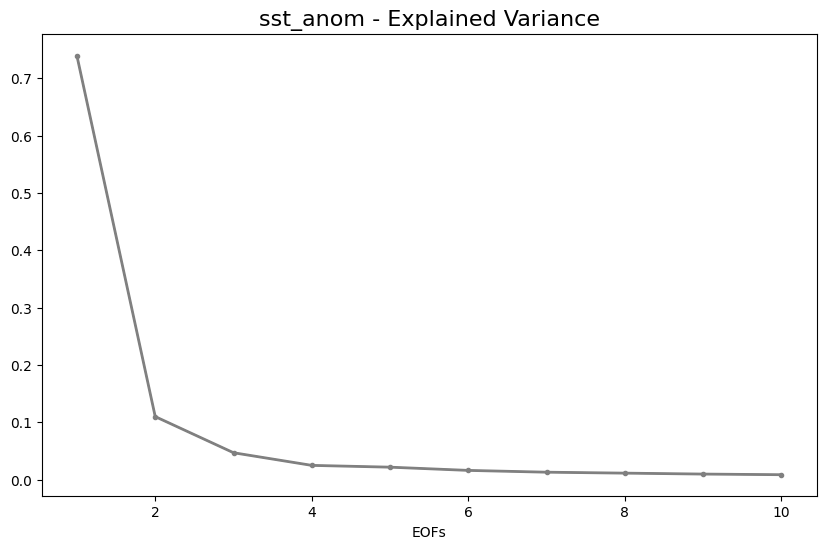

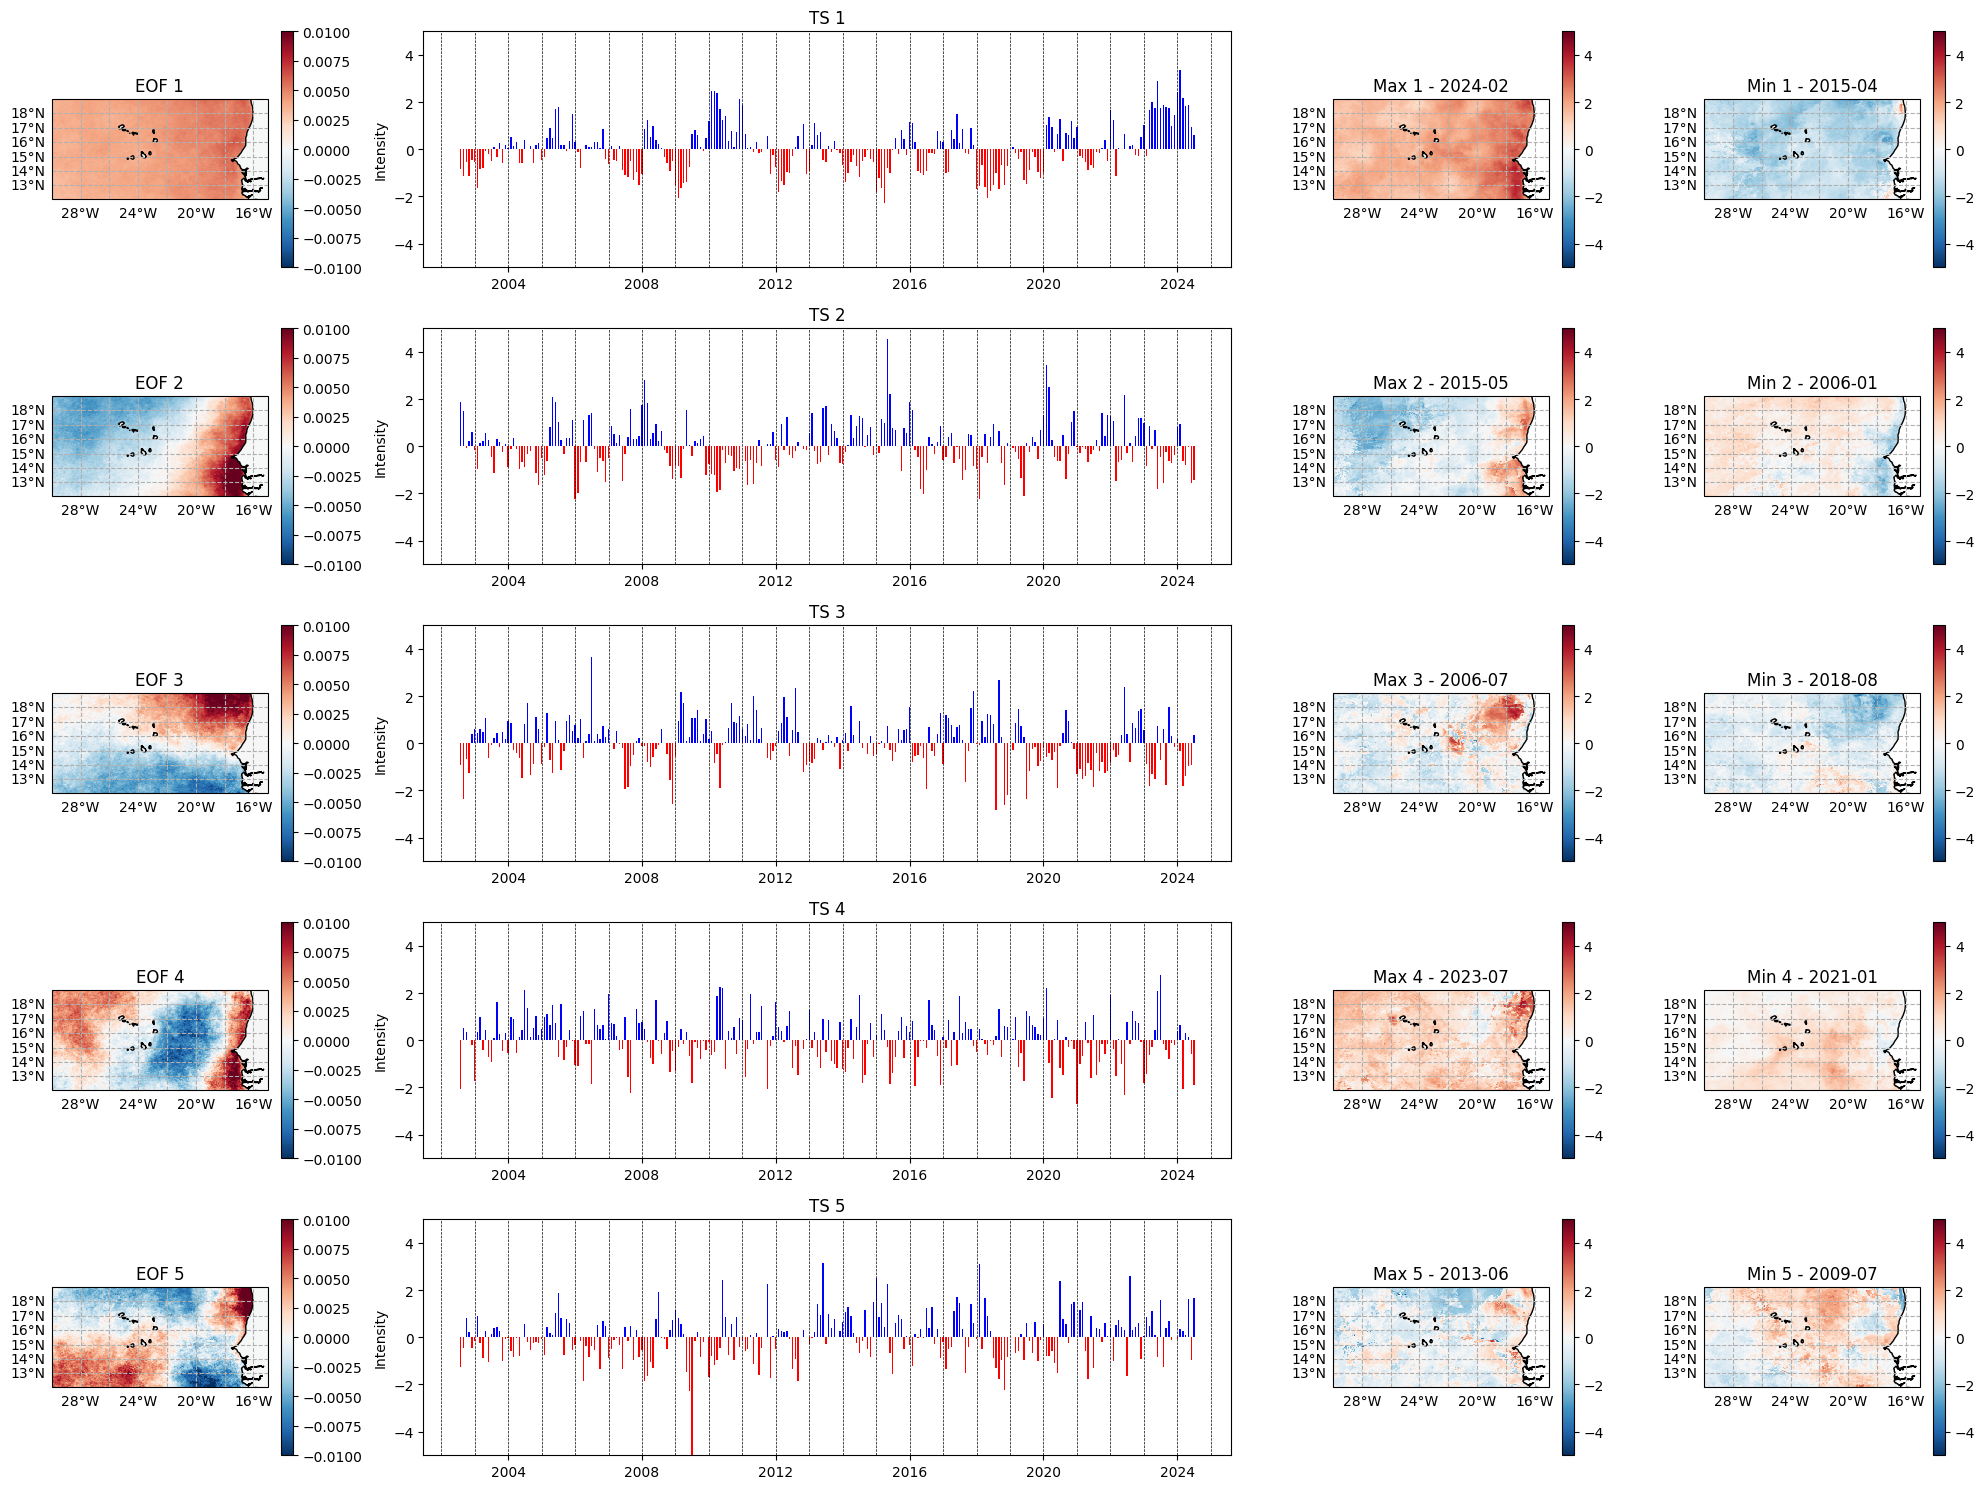

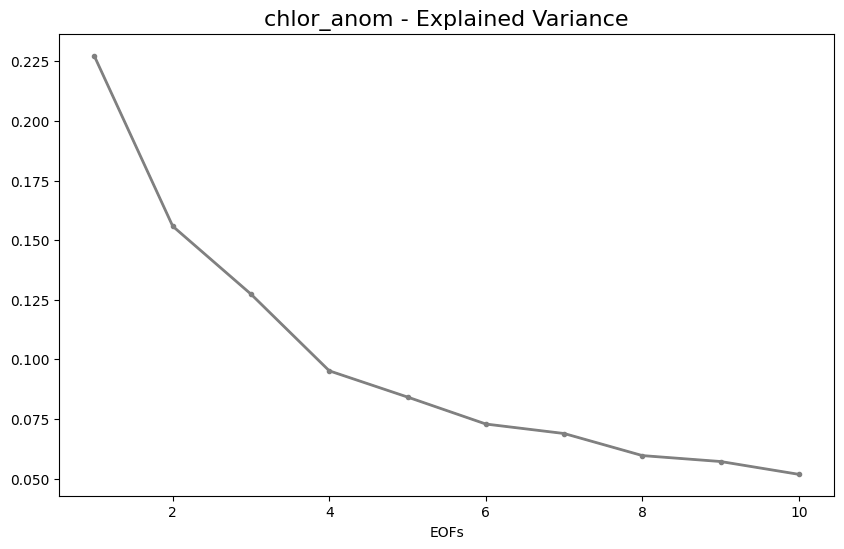

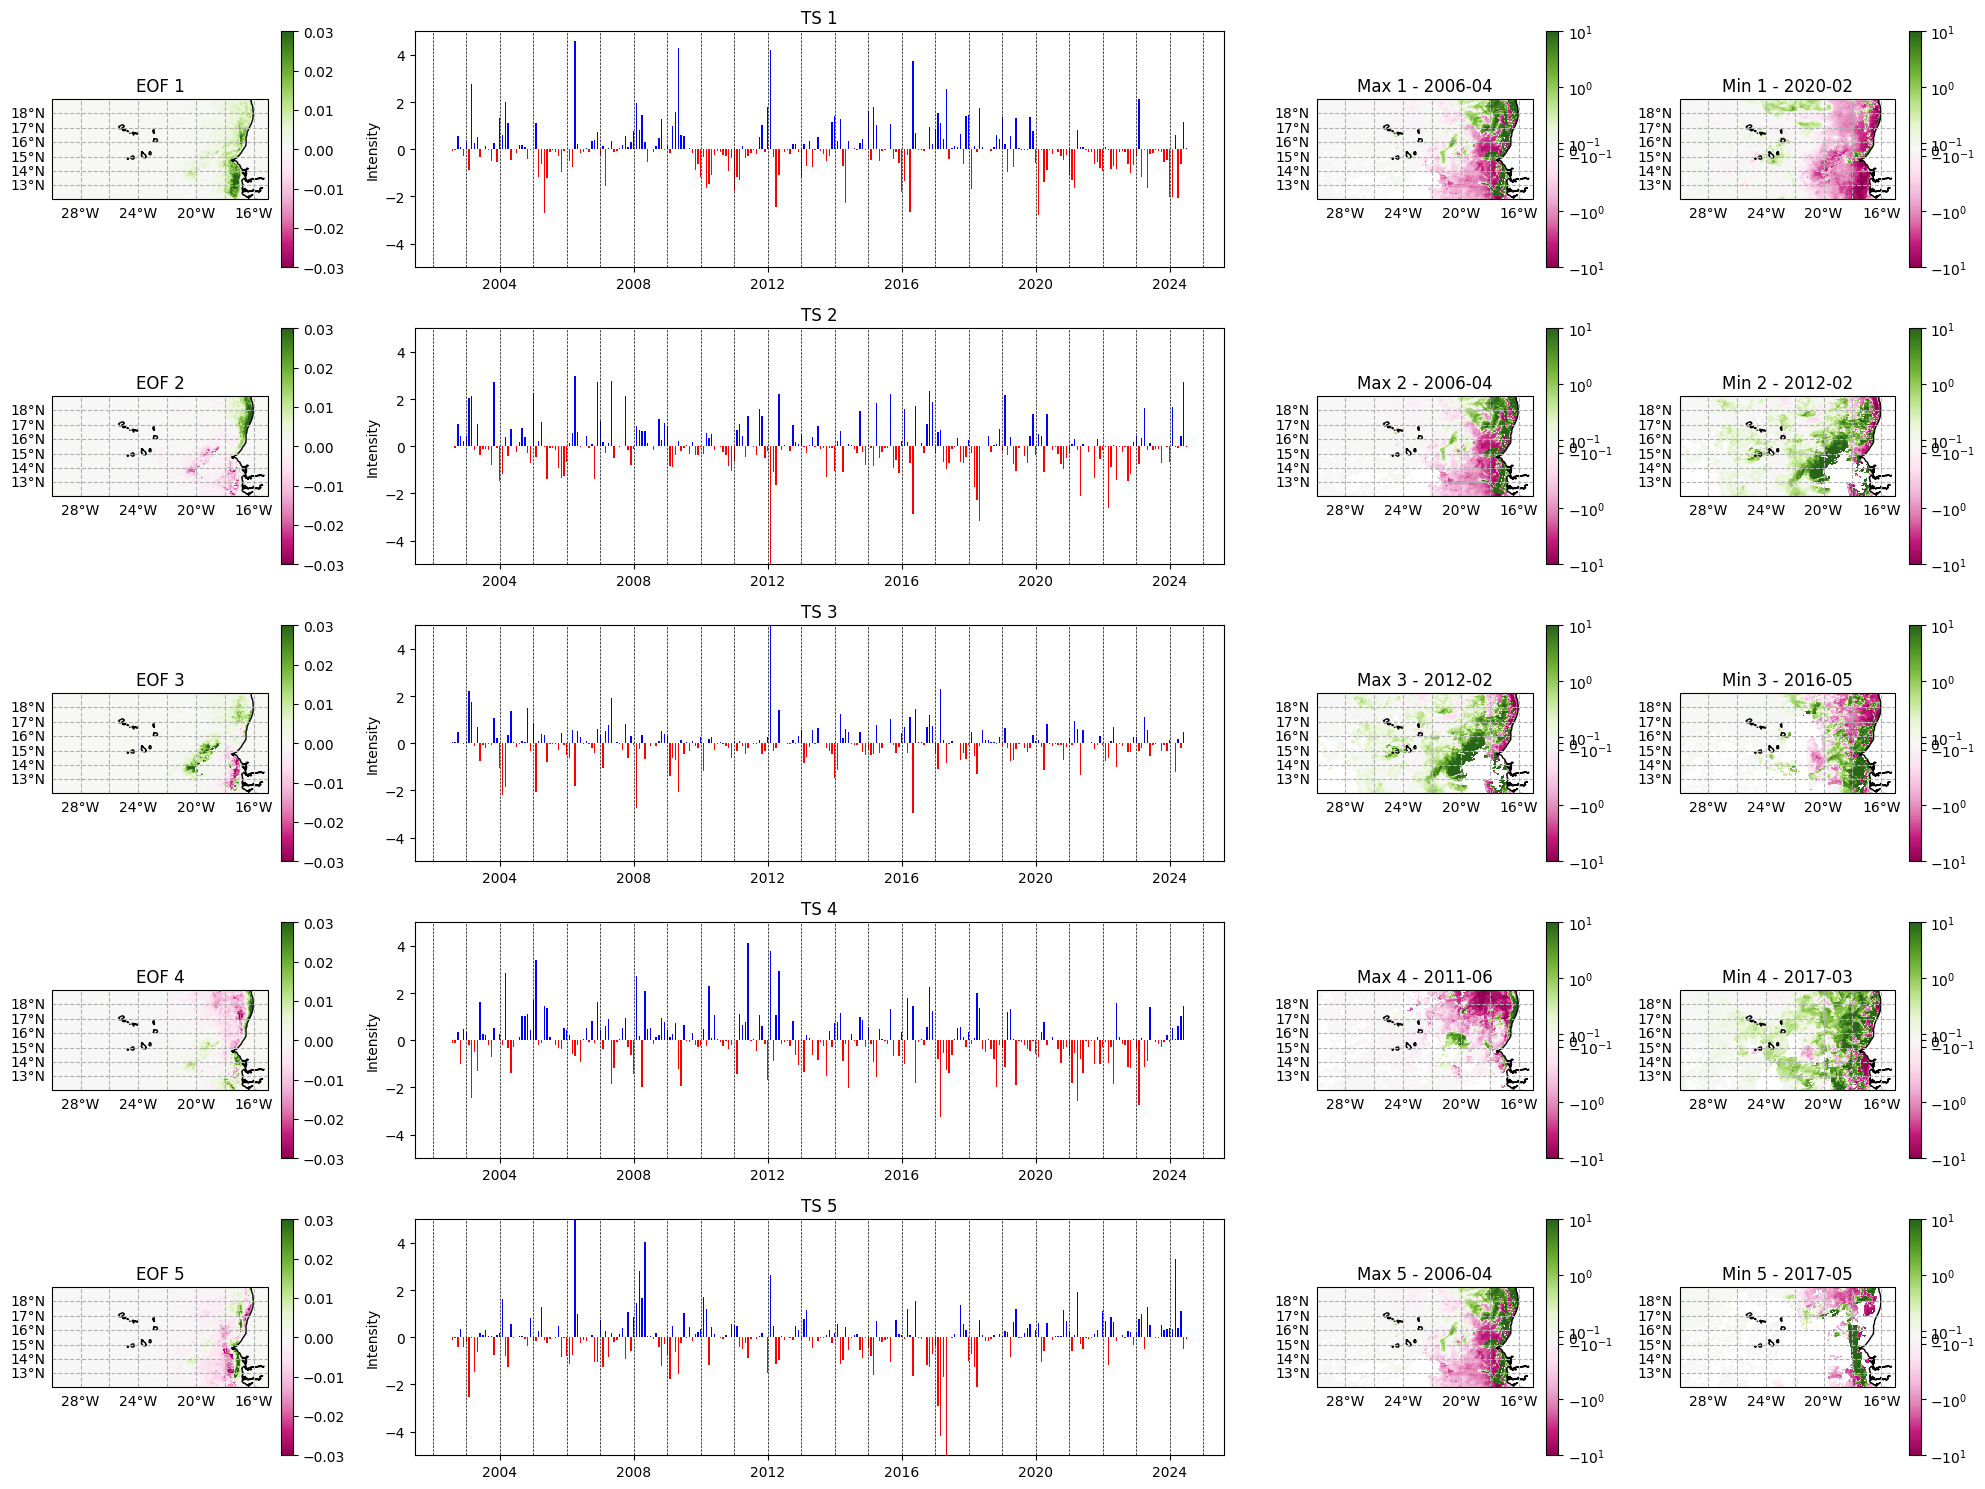

In [5]:
# Plot eigenvalues and explained variance.
for ds_name, data in eigenanalysis_results.items():
    plot_eigenvalues_explained_variance(data['LAM'], data['E'], 10, title=f"{ds_name} - Explained Variance")
    patterns, time_series = get_patterns_and_ts(data['E'], 5, len(ds_sst_raw.lat), len(ds_sst_raw.lon), data['ds_prep'])
    max_mins = get_pattern_ts_max_min(data['ds'], time_series, data['var_name'])
    plot_n_eof_report(
        patterns, 
        time_series, 
        max_mins, 
        data['ds'].lat, 
        data['ds'].lon, 
        data['ds'].time, 
        clim_pattern = [-0.03, 0.03] if data['var_name'] == 'chlor_a' else [-0.01, 0.01],
        clim_maxmin = [-10, 10] if data['var_name'] == 'chlor_a' else [-5, 5],
        cmap='PiYG' if data['var_name'] == 'chlor_a' else 'RdBu_r', 
        pat_norm_mode = 'none',
        maxmin_norm_mode = 'symlog' if data['var_name'] == 'chlor_a' else 'none',
        timeseries_type='enhanced_bars'
    )